In [1]:
import numpy as np
import tejapi
import matplotlib.pyplot as plt
tejapi.ApiConfig.api_key = "your key"

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 解決 plot中文問題
plt.rcParams['axes.unicode_minus'] = False

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.el2c6ple4zyw3eceviv3oxxgrn2nrfm2.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
data_return = tejapi.get('TWN/AAPRCM1',
                         coid = '0050',
                         mdate= {'gte': '2010-01-01','lte':'2015-12-31'},
                         opts={'columns':['coid','mdate','roi']},
                         chinese_column_name=True,paginate=True)

data_return['勝率'] = np.where(data_return['報酬率％_月'] >= 0 ,1,0)
data_return['勝率'] = data_return.rolling(12)['勝率'].sum() / 12

data_return['獲利'] = np.where(data_return['報酬率％_月'] >= 0 ,data_return['報酬率％_月'],np.nan)
data_return['虧損'] = np.where(data_return['報酬率％_月'] < 0 ,data_return['報酬率％_月'],np.nan)

data_return['賠率'] = data_return.rolling(12, min_periods=1)['獲利'].mean() \
    / data_return.rolling(12, min_periods=1)['虧損'].mean().abs()

In [3]:
data_return['下注比例'] = \
    np.where(data_return['勝率'] * data_return['賠率'] - (1 - data_return['勝率']) < 0,0,
             (data_return['勝率'] * data_return['賠率'] - (1 - data_return['勝率'])) / data_return['賠率']
             )

In [4]:
data_return['下注比例'] = data_return['下注比例'].shift() # 前一個月的下注比例
data_return = data_return.dropna(subset=['勝率']).reset_index(drop=True)

data_return.head(10)

,證券代碼,年月,報酬率％_月,勝率,獲利,虧損,賠率,下注比例
0,0050,2010-12-01 00:00:00+00:00,7.5308,0.583333,7.5308,NaN,1.223815,NaN
1,0050,2011-01-01 00:00:00+00:00,2.6058,0.666667,2.6058,NaN,1.340156,0.242868
2,0050,2011-02-01 00:00:00+00:00,-5.5555,0.666667,NaN,-5.5555,1.108934,0.417939
3,0050,2011-03-01 00:00:00+00:00,0.0842,0.666667,0.0842,NaN,0.951266,0.366078
4,0050,2011-04-01 00:00:00+00:00,4.1141,0.666667,4.1141,NaN,1.046112,0.316257
5,0050,2011-05-01 00:00:00+00:00,-0.0001,0.666667,NaN,-0.0001,2.201370,0.348026
6,0050,2011-06-01 00:00:00+00:00,-5.0807,0.666667,NaN,-5.0807,1.455108,0.515246
7,0050,2011-07-01 00:00:00+00:00,1.7844,0.666667,1.7844,NaN,1.157456,0.437589
8,0050,2011-08-01 00:00:00+00:00,-8.9315,0.666667,NaN,-8.9315,0.694984,0.378679
9,0050,2011-09-01 00:00:00+00:00,-5.3164,0.583333,NaN,-5.3164,0.543759,0.187039


In [5]:
data_return['報酬率％_月'] = data_return['報酬率％_月'] * 0.01


data_return['累積報酬率％_月'] = 1 + data_return['報酬率％_月']
data_return['累積報酬率％_月'] = data_return['累積報酬率％_月'].cumprod()

In [6]:
for i in range(0,len(data_return)):
    if i == 0:
        data_return['buy & hold本金'] = 1000000 # 起始本金
    else:
        data_return.loc[i,'buy & hold本金'] = 1000000 * data_return.loc[i-1,'累積報酬率％_月']

In [7]:
for i in range(0,len(data_return)):
    if i == 0:
        data_return['凱利本金'] = 1000000 # 起始本金
    else:
        if data_return.loc[i,'下注比例'] > 0:
            data_return.loc[i,'凱利本金'] = data_return.loc[i-1,'凱利本金'] * (1 - data_return.loc[i,'下注比例']) \
                + data_return.loc[i-1,'凱利本金'] * data_return.loc[i,'下注比例'] * (1 + data_return.loc[i,'報酬率％_月']) 
        else:
            data_return.loc[i,'凱利本金'] = data_return.loc[i-1,'凱利本金']
            
data_return.head(5)

,證券代碼,年月,報酬率％_月,勝率,獲利,虧損,賠率,下注比例,累積報酬率％_月,buy & hold本金,凱利本金
0,0050,2010-12-01 00:00:00+00:00,0.075308,0.583333,7.5308,NaN,1.223815,NaN,1.075308,1.000000e+06,1.000000e+06
1,0050,2011-01-01 00:00:00+00:00,0.026058,0.666667,2.6058,NaN,1.340156,0.242868,1.103328,1.075308e+06,1.006329e+06
2,0050,2011-02-01 00:00:00+00:00,-0.055555,0.666667,NaN,-5.5555,1.108934,0.417939,1.042033,1.103328e+06,9.829631e+05
3,0050,2011-03-01 00:00:00+00:00,0.000842,0.666667,0.0842,NaN,0.951266,0.366078,1.042910,1.042033e+06,9.832661e+05
4,0050,2011-04-01 00:00:00+00:00,0.041141,0.666667,4.1141,NaN,1.046112,0.316257,1.085817,1.042910e+06,9.960595e+05


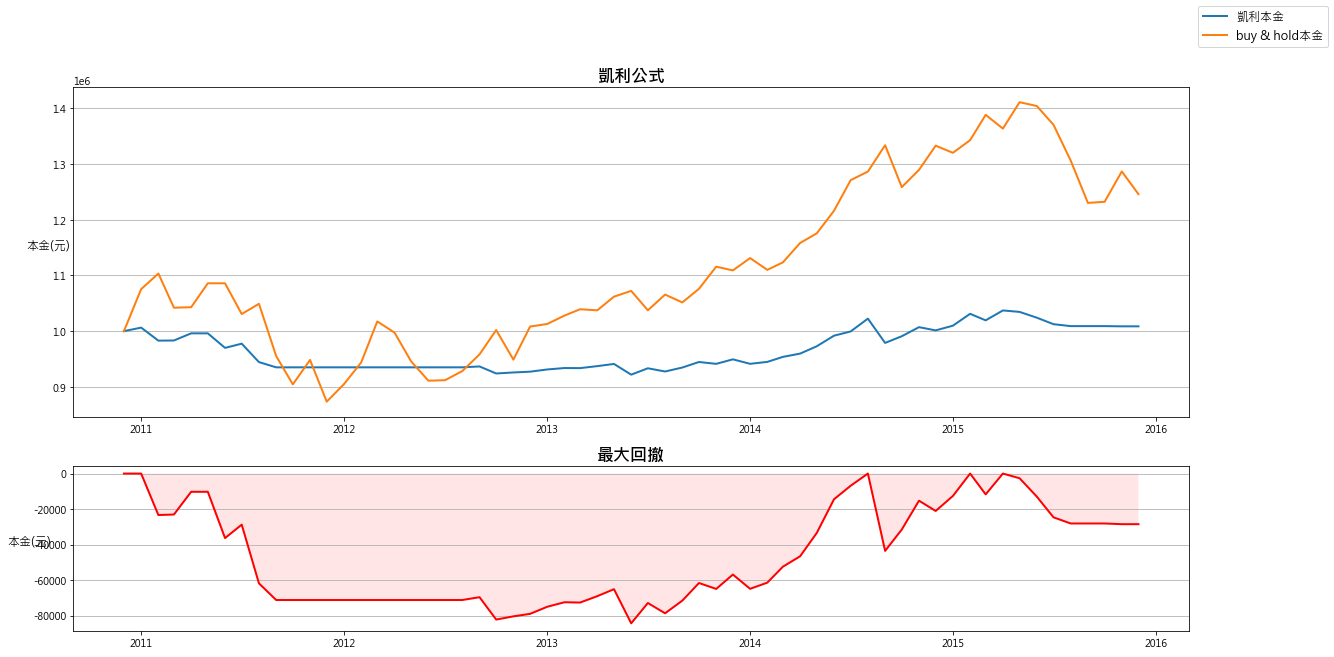

In [8]:
data_return = data_return.set_index('年月')

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,10), gridspec_kw={'height_ratios': [2,1]})
   
ax1.set_title('凱利公式', fontsize=17, fontweight='bold')
ax1.plot(data_return['凱利本金'], linewidth=2, alpha=1)
ax1.plot(data_return['buy & hold本金'], linewidth=2, alpha=1)
ax1.set_ylabel('本金(元)', fontsize=12,rotation=0)
ax1.grid(axis='y')
fig.legend(['凱利本金','buy & hold本金'], prop={'size': 12})

ax2.plot(data_return['凱利本金'] - data_return['凱利本金'].cummax(),linewidth=2, alpha=1, color='r')
ax2.fill_between(data_return.index, 0 ,
                 data_return['凱利本金'] - data_return['凱利本金'].cummax(),
                 facecolor='r', alpha=0.1)
ax2.set_title("最大回撤", fontsize=17, fontweight='bold')
ax2.set_ylabel('本金(元)', fontsize=12,rotation=0)
ax2.grid(axis='y')